# SIMPLE SYNTHESIZER 

In this assignment we will mostly explore the basic sine wave
oscillator and playing simple melodies using it. A reasonable "hello
world" of sound synthesis can be a tuning note i.e creating 3 seconds
a sine wave at 440Hz sampled at a typical audio sampling rate such as
44100 or 48000 samples per second.

Similarly to "hello world" this program does not do anything particularly
interesting but completing it ensures that you are able to compile and
interpret your code, generate an audio signal, and hear it which at
the end of the day is all you need to experiment with sound synthesis using
software.

I will use the term familiar programming language to refer to the ones
that you probably have encountered during your studies: Python, C,
C++, Java, and Javascript. As you probably can guess I will use the
term unfamiliar programming language to refer to any other programming
language such as: Haskell, OCaml, Prolog, Rust, Go, Julia, Ruby, C#, F#
R, etc.

For all basic questions (1,2,3,4) use a familiar programming language. 

1. (Basic)

Create an array of digital samples corresponding to 3
seconds of a 440Hz sinusoid with a sampline rate of 44100 samples per
second. Either play the resulting tone directly if your language
supports it (feel free to use a library if one is available) or write
a sound file that you can listen to using some external program such
as the Audacity audio editor. You are allowed to use a soundfile
reading/writing library if you can find one for the language you are
using or you can write one yourself (there are many resources
documenting the .wav file format for example
https://docs.fileformat.com/audio/wav/ - you don't need to implement
all possible options just get one basic one working. Use a familiar
programming language. 

In [2]:
import numpy as np
import IPython.display as ipd
import math
import matplotlib.pyplot as plt

In [3]:
srate = 44100      # sampling rate 
duration = 3       # duration in seconds 
freq = 440         # frequency 

t = np.linspace(0,duration,srate*duration)
data =  np.sin(2*np.pi*freq*t)

# play the corresponding audio 
ipd.Audio(data,rate=srate)

2. (Basic)

Using the code you wrote in question 1 create a function that
takes as arguments a MIDI note number and a duration and similarly
generates a sinusoidal sound. Use this function to create a simple
recognizable melody by concatenating the corresponding arrays with
appropriate pitches and durations. If you can't think of a melody
Bicycle made for two (Daisy, Daisy) or the star wars theme or
happy birthday are common choices. 

In [4]:
srate=44100
freq=440

def generate_sound(note, duration):
    f = (freq/32) * (2 ** ((note-9)/12))
    t = np.linspace(0, math.ceil(duration), math.ceil(srate*duration))
    return np.sin(2*np.pi*f*t)

In [5]:
# Test - Bicycle Made for Two
data=[(79,1),(76,1),(72,1),(67,1),(69,0.3),(71,0.3),(72,0.3),(69,0.6),(72,0.3),(67,1)]
output=[generate_sound(a,b) for (a,b) in data]
ipd.Audio(np.hstack(output),rate=srate)

3. (Basic)

Now generalize your code to take as input a simple score language.
The score language should specifiy pitches and durations and include
rests (silent duration). You can choose how you represent pitches
in terms of relative or absolute encoding or similarly how your represent
durations (absolute time or as a fractions of measures at a specified tempo)
or using NoteOn and NoteOff events. You can use a subset of SKINI
(https://ccrma.stanford.edu/software/stk/skini.html)
if you don't want to make up your own format.  

In [6]:
# start duration MIDInote
# -1 means silence, MIDInote=0
score = """
0 1 79
1 1 76
2 1 72
3 1 67
-1 1 0
5 0.3 69
5.3 0.3 71
5.6 0.3 72
5.9 0.6 69
6.5 0.3 72
6.8 1 67
"""

def generate_sound(note, duration, start):
    f = (freq/32) * (2 ** ((note-9)/12))
    t = np.linspace(0, math.ceil(duration), math.ceil(srate*duration))
    return (start, np.sin(2*np.pi*f*t))

def parse_score(score):
    lines = filter(lambda x: x, score.split('\n'))
    notes = map(lambda line: map(float, line.split()), lines)
    return notes

def generate_sound_from_score(score):
    notes = parse_score(score)
    samples =[generate_sound(pitch, duration, start) for (start, duration, pitch) in notes]
    output = [0] * (math.ceil(samples[-1][0] * srate) + 10)
    for sample in samples:
        start = math.ceil(sample[0] * srate + 1)
        output[start : len(sample[1]) + start] = sample[1]
    return np.array(output)
    
ipd.Audio(generate_sound_from_score(score),rate=srate)

4. (Basic) 

Implement the following oscillators: Sawtooh, Pulse, Triangle and Noise
There are different ways to implement some of them - any reasonable
implementation is fine. 



In [7]:
def sawtooth(x):
    return x % 10

def triangle(x):
    x %= 10
    return x if x < 5 else 10 - x
    
def pulse(x):
    return x % 10 < 5

def noise(x):
    return np.random.normal(0, 1.0, len(x))

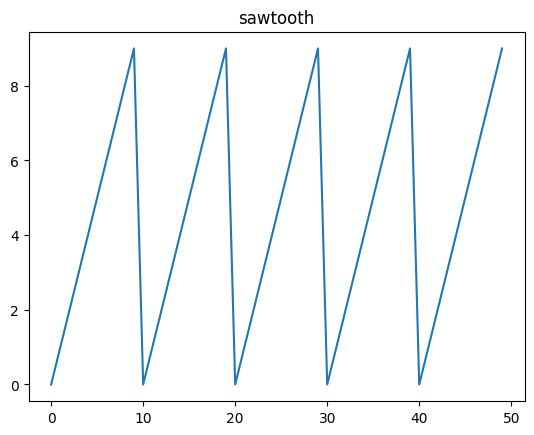

In [7]:
duration=1
srate = 44100

x = np.arange(0,srate*duration, duration)
y = sawtooth(x)[:50]
plt.title("sawtooth")
plt.plot(y)

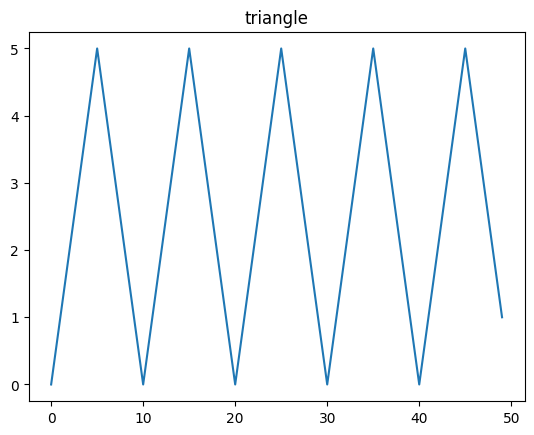

In [8]:
y = list(map(triangle, x))[:50]
plt.title("triangle")
plt.plot(y)

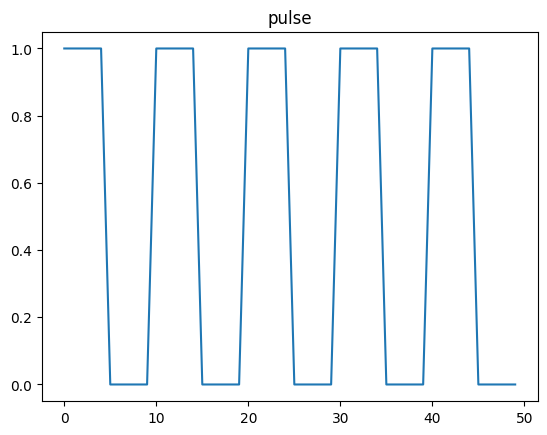

In [9]:
y = pulse(x)[:50]
plt.title("pulse")
plt.plot(y)

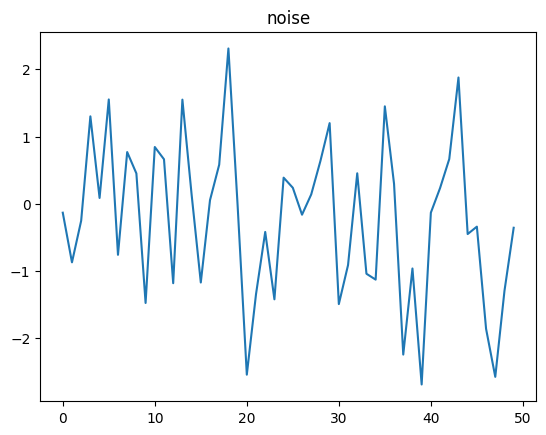

In [10]:
y = noise(x)[:50]
plt.title("noise")
plt.plot(y)

5. (Expected)

Software that processes digital audio typically operates using buffers
of samples. Re-implement questions 1,2,3,4 but using buffers. For
example, to create a sinusoid for 1 second your oscillator function
will be called multiple times to generate a user-provided number of
samples (256, 512, 1024 are common buffer sizes). You will need to
keep track of where you are in terms of the signal so that no
discontinuities are created. If you are using a software library for
playing audio that is based on call-backs you can implement your
buffered oscillators as call-back functions.

In [16]:
#=========================
# Lecture code
#=========================

class WavetableOscillator:
    
    def create_wavetable(self, length, fn): 
        L = length+1 # add one sample to wavetable to allow edge interpolation
        t = np.linspace(0, 1.0 , L)
        wavetable = fn(2 * np.pi * t)
        return wavetable
    
    def wavetable_lookup(self, phase_index, wavetable, mode): 
        if (mode == 'truncate'): 
            return wavetable[int(phase_index)]
        elif (mode == 'round'): 
            return wavetable[round(phase_index)]
        elif (mode == 'interpolate'): 
            x  = phase_index
            x0 = int(phase_index)
            x1 = x0+1
            y0 = wavetable[x0]
            y1 = wavetable[x1]
            return y0 * (x1-x) + y1 * (x - x0)
        else:
            return 0.0 

    def __init__(self, nsamples=1024, fn=np.sin, table_length=1000, freq=220, srate=44000):
        self.phase_index = 0.0 
        self.table_length = table_length 
        self.wavetable = self.create_wavetable(self.table_length, fn)
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        self.freq = freq
        self.srate = srate 
    
    def set_nsamples(self, nsamples): 
        self.nsamples = nsamples 
        self.data = np.zeros(nsamples)
        
    def process(self): 
        for t in np.arange(self.nsamples): 
            phase_increment = (self.table_length * self.freq) / self.srate 
            self.phase_index = (self.phase_index + phase_increment) % self.table_length
            sample = self.wavetable_lookup(self.phase_index, self.wavetable, mode='interpolate')
            self.data[t] = sample
        return self.data 

In [17]:
#====================================================================
# Note: We could play audio with the following code from the lecture
#====================================================================

import time 
import sys
import pyaudio

osc1 = WavetableOscillator(nsamples=1024)

def callback(in_data, frame_count, time_info, status):
    osc1.set_nsamples(frame_count)
    data = osc1.process()
    return (data.astype(np.float32).tobytes(), pyaudio.paContinue)

 # Instantiate PyAudio and initialize PortAudio system resources (2)
p = pyaudio.PyAudio()

stream = p.open(format=pyaudio.paFloat32,
                channels=1,
                rate=48000,
                output=True,
                stream_callback=callback)

time.sleep(2.0)
print('Playback done')
stream.close()
p.terminate()

ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:877:(find_matching_chmap) Found no matching channel map
ALSA lib dlmisc.c:337:(snd_dlobj_cache_get0) Cannot open shared library libasound_module_pcm_pipewire.so (/home/vinguyen/anaconda3/envs/synthenv/lib/alsa-lib/libasound_module_pcm_pipewire.so: cannot open shared object file: No such file or directory)
ALSA lib dlmisc.c:337:(snd_dlobj_cache_get0) Cannot open shared library libasound_module_pcm_pipewire.so (/home/vinguyen/anaconda3/envs/synthenv/lib/alsa-lib/libasound_module_pcm_pipewire.so: cannot open shared object file

Playback done


To demonstrate the code, I will plot the oscillator instead of generating audio

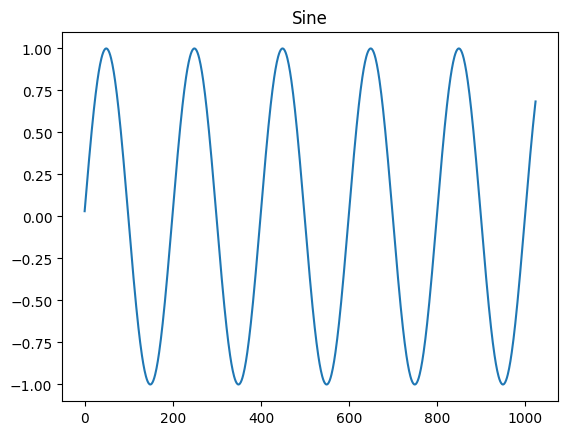

In [18]:
# Question 1 - Sine
osc1 = WavetableOscillator(nsamples=1024, fn=np.sin)
data = osc1.process()
plt.title("Sine")
plt.plot(data)

In [19]:
# Question 2
srate=44000
freq=440

def generate_sound_with_table(note, duration):
    f = (freq/32) * (2 ** ((note-9)/12))
    osc = WavetableOscillator(nsamples=math.ceil(44000 * duration), table_length=1000, fn=np.sin, freq=f)
    return osc.process()

data=[(79,1),(76,1),(72,1),(67,1),(69,0.3),(71,0.3),(72,0.3),(69,0.6),(72,0.3),(67,1)]
output=[generate_sound_with_table(a,b) for (a,b) in data]
ipd.Audio(np.hstack(output),rate=srate)

In [20]:
# Question 3
# start duration MIDInote
# -1 means silence, MIDInote=0
score = """
0 1 79
1 1 76
2 1 72
3 1 67
-1 1 0
5 0.3 69
5.3 0.3 71
5.6 0.3 72
5.9 0.6 69
6.5 0.3 72
6.8 1 67
"""

def generate_sound_with_table(note, duration, start):
    f = (freq/32) * (2 ** ((note-9)/12))
    osc = WavetableOscillator(nsamples=math.ceil(44000 * duration), table_length=1000, fn=np.sin, freq=f)
    return (start, osc.process())

def parse_score(score):
    lines = filter(lambda x: x, score.split('\n'))
    notes = map(lambda line: map(float, line.split()), lines)
    return notes

def generate_sound_from_score(score):
    notes = parse_score(score)
    samples =[generate_sound_with_table(pitch, duration, start) for (start, duration, pitch) in notes]
    output = [0] * (math.ceil(samples[-1][0] * srate) + 10)
    for sample in samples:
        start = math.ceil(sample[0] * srate + 1)
        output[start : len(sample[1]) + start] = sample[1]
    return np.array(output)
    
ipd.Audio(generate_sound_from_score(score),rate=srate)

In [55]:
# Question 4
def sawtooth(x):
    return (x - np.pi)/np.pi

def triangle(x):
    return 1 - 2 * np.abs(sawtooth(x))
    
def pulse(x):
    return x % 10 < 5

def noise(x):
    return np.random.normal(0, 1.0, len(x))

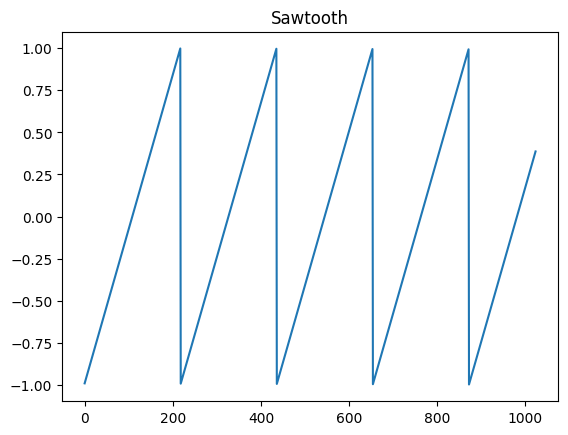

In [56]:
osc1 = WavetableOscillator(nsamples=1024, fn=sawtooth)
data = osc1.process()
plt.title("Sawtooth")
plt.plot(data)

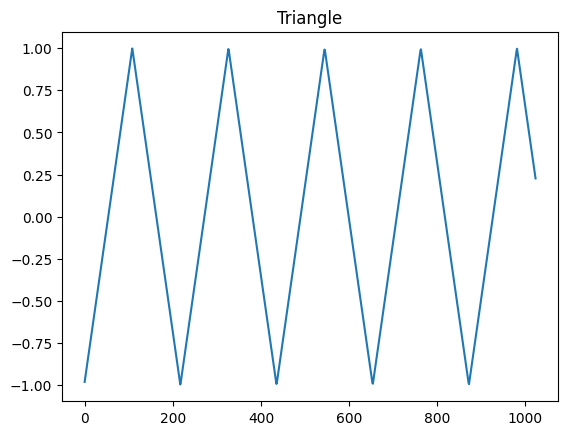

In [57]:
osc1 = WavetableOscillator(nsamples=1024, fn=triangle)
data = osc1.process()
plt.title("Triangle")
plt.plot(data)

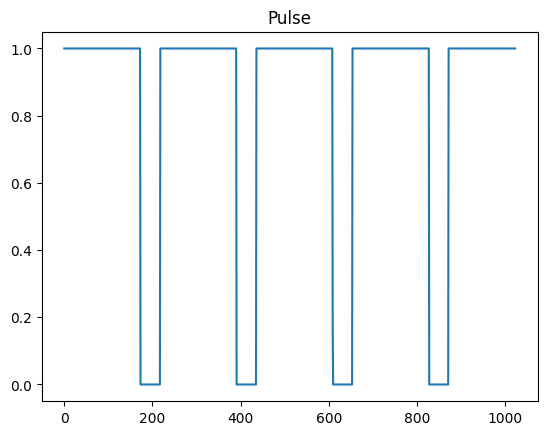

In [58]:
osc1 = WavetableOscillator(nsamples=1024, fn=pulse)
data = osc1.process()
plt.title("Pulse")
plt.plot(data)

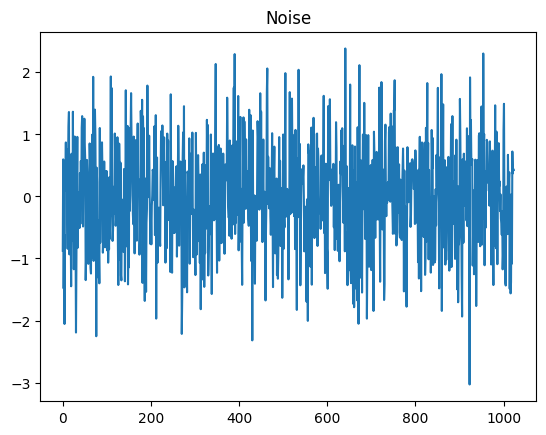

In [59]:
osc1 = WavetableOscillator(nsamples=1024, fn=noise)
data = osc1.process()
plt.title("Noise")
plt.plot(data)

6. (Expected)

Extend the monophonic synthesizer you created in the previous
questions to support polyphony and multiple oscillators. You can
implement polyphony using a fixed number of oscillators (one for each
voice) and do not need to deal with any smart voice allocation. Check
to see what level of polyphony you can support with your
implementation on your computer by increasing the number of
oscillators gradually until you can not keep up with real time.

7. (Expected)

Implement some of the basic functionality (questions 1,2)
using a visual programming language (Max/MSP or PureData or feel free
to suggest other ones)

8. (Expected)

Implement all of the basic functionality (questions
1,2,3,4) using a textual programming language that is designed for
sound and music (Csound, Nyquist, Chuck, Supercollider, Faust). Only
one language implementation is required for full marks.

There are 4 advanced questions. You only need to implement 2 of them
for full marks.


9. (Advanced)

Implement all functionality of the simple synthesizer (questions
1,2,3,4,5,6) using an unfamiliar programming language.

10. (Advanced)

Look into how one can implement the sin/cos function without using
built-in library implementations. Typically implementation use a
combination of polynomial approximations (Taylor Series, Chebyshev
polynomials) and wavetable interpolation. Implement the sine function
using 3 different approaches (different polynomial orders can be
considered different approaches) and compare them in terms of time and
memory requirements. Any programming language can be used for this
question.

11. (Advanced) 

Implement all functionality of the simple synthesizer (questions
1,2,3,4,5,6) as a AudioUnit/VST plugin using the JUCE software
framework in C++.  - you don't need to directly implement the score
but can respond to MIDI input.

12. (Advanced) 

Implement all the functionity of the simple synthesizer (questions
1,2,3,3,4,5,6) as a VCV Rack modular component.